# Intiallization & Forward pass


In [42]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
EPSILON = 0.1


mat_data = loadmat('/content/GMMData.mat')
ctrain = mat_data['Ct'].T
xtrain = mat_data['Yt']
cvalid = mat_data['Cv'].T
xvalid = mat_data['Yv']

ones_row = np.ones((1, xtrain.shape[1]))  # Create a row vector of ones with the same number of columns as the matrix
xtrain = np.vstack([xtrain, ones_row])

ones_row = np.ones((1, xvalid.shape[1]))  # Create a row vector of ones with the same number of columns as the matrix
xvalid = np.vstack([xvalid, ones_row])



def generate_weights(hidden_neurons, input_dim, num_classes):
    weights = []
    weights.append(np.random.randn(hidden_neurons[0], input_dim))

    for i in range(len(hidden_neurons) - 1):
        weights.append(np.random.randn( hidden_neurons[i+1] , hidden_neurons[i] + 1))

    weights.append(np.random.randn(num_classes, hidden_neurons[-1]))
    return weights



hidden_neurons = [7, 9, 8 , 10]
input_dim = xtrain.shape[0]
num_classes = ctrain.shape[1]
print(num_classes)
weights = generate_weights(hidden_neurons, input_dim, num_classes)




# print(f"[DEBUG] xtrain with shape {xtrain.shape}\n")
print(f"Hidden neurons are : : {hidden_neurons}")

for i, w in enumerate(weights) :
  # print(f"[DEBUG] weights[{i}] with shape {weights[i].shape} :\n {weights[i]}")
  print(f"[DEBUG] weights[{i}] with shape {weights[i].shape} ")


5
Hidden neurons are : : [7, 9, 8, 10]
[DEBUG] weights[0] with shape (7, 6) 
[DEBUG] weights[1] with shape (9, 8) 
[DEBUG] weights[2] with shape (8, 10) 
[DEBUG] weights[3] with shape (10, 9) 
[DEBUG] weights[4] with shape (5, 10) 


In [8]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
EPSILON = 0.1


def forward(inputs, weights):
        x = inputs
        cache = [inputs]
        for i in range(len(weights) - 1): #2
          x = np.tanh(weights[i] @ x)   # σ(W(l) o xi(l) + b(l))) -> σ(W(l) o xi(l)))

          ones_row = np.ones((1, x.shape[1]))
          if i != len(weights) - 2:
            x = np.vstack([x, ones_row])
          cache.append(x)

          # print(f"tanh(W[{i}] * X) \n : {x}")

        # to remove the tanh.
        softmax_output = softmax(weights[-1] @ x) # removed the ones row.
        return softmax_output, cache


def softmax(output):
    # print(f"[DEBUG]Output is with shape {output.shape}: \n {output}")
    # Subtracting the maximum value for each row to prevent overflow
    max_output = np.max(output, axis=0, keepdims=True)
    exp_output = np.exp(output - max_output)
    res = exp_output / np.sum(exp_output, axis=0, keepdims=True)
    # print(f"[DEBUG]result of sum is : \n {np.sum(res, axis=0, keepdims=True)}")

    return res




In [30]:
# last, rest = forward(inputs,weights)
last, rest = forward(xtrain,weights)

# print("Give layers are without ones (or using b):")
# print(f"{xtrain.shape[0] - 1}, {weights[0].shape[1] - 1}, {weights[1].shape[1] - 1}, {last.shape[0]}")

print("Give layers are with ones:")
print(f"{xtrain.shape[0]}, {weights[0].shape[0]}, {weights[1].shape[0]}, {last.shape[0]}")

print(f"[DEBUG] xtrain with shape {xtrain.shape}")

for i,w in enumerate(rest) :
  print(f"[DEBUG] rest[{i}] with shape {rest[i].shape}")



# LAYER 0       LAYER 1         LAYER 2
for i,w in enumerate(weights) :
  print(f"[DEBUG] weights[{i}] with shape {weights[i].shape} ")

Give layers are with ones:
3, 7, 9, 2
[DEBUG] xtrain with shape (3, 20000)
[DEBUG] rest[0] with shape (3, 20000)
[DEBUG] rest[1] with shape (8, 20000)
[DEBUG] rest[2] with shape (10, 20000)
[DEBUG] rest[3] with shape (9, 20000)
[DEBUG] rest[4] with shape (10, 20000)
[DEBUG] weights[0] with shape (7, 3) 
[DEBUG] weights[1] with shape (9, 8) 
[DEBUG] weights[2] with shape (8, 10) 
[DEBUG] weights[3] with shape (10, 9) 
[DEBUG] weights[4] with shape (2, 10) 


In [31]:
def compute_loss(output, labels):
    m = labels.shape[0] # TODO: To change 3 samples.
    logmat = np.log(output)
    total_loss = labels.T * logmat
    total_loss = -np.sum(total_loss)/m
    return total_loss

out , _ = forward(xtrain, weights)
compute_loss(out, ctrain)


3.576990910782366

# GRAD OF THE LAST LAYER

In [32]:
# gardient of softmax wrt W.
def grad_w_softmax(inputs, labels, weights):
    labels = np.array(labels)
    m = labels.shape[0] # num of samples.
    output, rest = forward(inputs, weights)
    temp = []

    pred_actu = (output.T - labels).T
    for p in range(labels.shape[1]): # num of classes.
        temp.append(np.dot(rest[-1], (pred_actu[p]))/m) # (2, 4) x (4,1) -> (2,5)
    return temp


# test of the gradient of softmax wrt W.
def gradient_test_w(inputs, labels, num_steps):

    F0 = compute_loss(output=out, labels=labels)
    y0 = np.zeros(num_steps)
    y1 = np.zeros(num_steps)

    epsilon = 0.1

    d = []
    for i in range(len(weights)):
        d.append(np.random.randn(
            weights[i].shape[0], weights[i].shape[1]))

    g_0 = grad_w_softmax(inputs, labels, weights)
    g_0 = np.array(g_0)
    d = np.array(d)


    print("k\terror order 1 \t\t error order 2")
    for k in range(1, num_steps + 1):
        epsk = epsilon * (0.5 ** k)
        wk = []
        for i in range(len(weights)):
            wk.append(d[i] * epsk + weights[i])


        Fk = compute_loss(output=out, labels=labels)
        F1 = F0 + (epsk * np.sum(d * g_0))
        y0[k - 1] = abs(Fk - F0)
        y1[k - 1] = abs(Fk - F1)

        print(k, "\t", abs(Fk - F0), "\t", abs(Fk - F1))

    plt.semilogy(range(1, num_steps+1), y0)
    plt.semilogy(range(1, num_steps+1), y1)

    plt.legend(("Zero order approx", "First order approx"))
    plt.title("Successful Grad test in semilogarithmic plot")
    plt.xlabel("k")
    plt.ylabel("error")
    plt.show()



In [33]:
# gardient of softmax wrt X.
def grad_x_softmax(inputs, labels, weights):
    m = labels.shape[0] # num of samples.
    output, _ = forward(inputs, weights)
    temp = []


    pred_actu = (output.T - labels).T
    return ((np.dot(weights[-1].T , pred_actu))/m) # (2,5) @ (5,4) = (2,4).


# WORKS only for one layer.
# test of the gradient of softmax wrt X.
def gradient_test_x(inputs, labels, num_steps):
    F0 = compute_loss(inputs=inputs, labels=labels, weights=weights)
    y0 = np.zeros(num_steps)
    y1 = np.zeros(num_steps)

    epsilon = 0.1

    # the change will be on d,
    g_0 = grad_x_softmax(inputs, labels, weights)
    g_0 = np.array(g_0)

    d = np.random.randn(*inputs.shape)

    d = np.array(d)

    print("k\terror order 1 \t\t error order 2")
    for k in range(1, num_steps + 1):
        epsk = epsilon * (0.5 ** k)
        ink = d * epsk + inputs
        Fk = compute_loss(ink, labels, weights)
        F1 = F0 + (epsk * np.sum(d * g_0))
        y0[k - 1] = abs(Fk - F0)
        y1[k - 1] = abs(Fk - F1)

        print(k, "\t", abs(Fk - F0), "\t", abs(Fk - F1))

    plt.semilogy(range(1, num_steps+1), y0)
    plt.semilogy(range(1, num_steps+1), y1)

    plt.legend(("Zero order approx", "First order approx"))
    plt.title("Successful Grad test in semilogarithmic plot")
    plt.xlabel("k")
    plt.ylabel("error")
    plt.show()



#  JACOBIAN TEST OF THE HIDDEN LAYERS


In [34]:
from types import prepare_class
def tan_derv(x) :
  return 1 - np.tanh(x) ** 2

def grad_w_layers(x, w, v):
  return (tan_derv(np.dot(w,x)) * v) @ x.T

def grad_x_layers(x, w, v):
  inputs_removed = w.T @ (tan_derv(np.dot(w,x)) * v)
  return inputs_removed[:-1, :]

def g(fx, u):
    return np.sum(fx * u)


def direct_jacobian_test_transposed_w(x, w, num_steps):

    y0 = np.zeros(num_steps)
    y1 = np.zeros(num_steps)
    output = np.tanh(w @ x)

    epsilon = 0.1
    u =  np.random.randn(output.shape[0], output.shape[1])
    J = grad_w_layers(x, w, u) # first hidden layer.

    d = np.random.randn(w.shape[0], w.shape[1])


    F0 = g(output, u)
    print("k\terror order 1 \t\t error order 2")

    for k in range(1, num_steps + 1):
        epsk = epsilon * (0.5 ** k)
        wk = d * epsk + w

        fx = np.tanh((np.dot(wk, x)))
        Fk = g(fx, u)
        F1 =  F0 + epsk * (np.sum(np.multiply(J, d)))

        y0[k - 1] = abs(Fk - F0)
        y1[k - 1] = abs(Fk - F1) # Fk - F1
        print(k, "\t", y0[k-1], "\t", y1[k-1])

    plt.semilogy(range(1, num_steps+1), y0)
    plt.semilogy(range(1, num_steps+1), y1)

    plt.legend(("Zero order approx", "First order approx"))
    plt.title("Grad Test of Hidden Layer wrt W")
    plt.xlabel("k")
    plt.ylabel("error")
    plt.show()


def direct_jacobian_test_transposed_x(x, w, num_steps):

    y0 = np.zeros(num_steps)
    y1 = np.zeros(num_steps)
    output = np.tanh(w @ x)


    epsilon = 0.1
    u =  np.random.randn(output.shape[0], output.shape[1])
    J = grad_x_layers(x, w, u) # first hidden layer.

    F0 = g(output,  u)
    d = np.random.randn(J.shape[0], J.shape[1])


    print("k\terror order 1 \t\t error order 2")
    for k in range(1, num_steps + 1):
        epsk = epsilon * (0.5 ** k)
        zeros_row = np.zeros((1, J.shape[1]))
        # Vertically stack d and zeros_row
        df = np.vstack([d, zeros_row])
        intk = df * epsk + x

        fx = np.tanh((np.dot(w, intk)))
        Fk = g(fx, u)
        F1 = F0 + np.sum(J * (d * epsk))

        y0[k - 1] = abs(Fk - F0)
        y1[k - 1] = abs(Fk - F1)
        print(k, "\t", y0[k-1], "\t", y1[k-1])

    plt.semilogy(range(1, num_steps+1), y0)
    plt.semilogy(range(1, num_steps+1), y1)

    plt.legend(("Zero order approx", "First order approx"))
    plt.title("Grad Test of Hidden Layer wrt x")
    plt.xlabel("k")
    plt.ylabel("error")
    plt.show()





Hidden layer 1 jacobian test  wrt x,w :



k	error order 1 		 error order 2
1 	 16.219177888243593 	 0.01822782186118843
2 	 8.113197490045906 	 0.005505365006484908
3 	 4.057768729351039 	 0.0015826981751558833
4 	 2.029247674276718 	 0.0004280394863656056
5 	 1.014726381252217 	 0.0001114756293247865
6 	 0.5073904751764928 	 2.84532642922386e-05
7 	 0.25370227623665187 	 7.18798372645324e-06
8 	 0.126852925679799 	 1.8064303901610401e-06


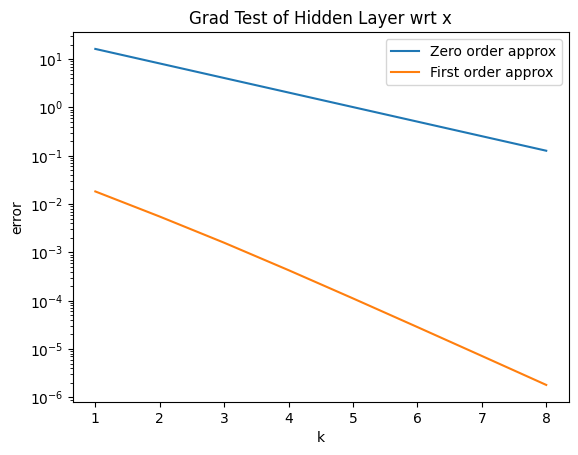

k	error order 1 		 error order 2
1 	 11.045336218158582 	 0.10381387566997091
2 	 5.500062248117587 	 0.029301076873281318
3 	 2.7431166185907756 	 0.007736032968622908
4 	 1.3696750724545126 	 0.001984779643436241
5 	 0.684347648958294 	 0.0005025025527629623
6 	 0.34204898478202495 	 0.00012641157925941116
7 	 0.1709929875789129 	 3.170097753013579e-05
8 	 0.08548858079529964 	 7.93749460115123e-06


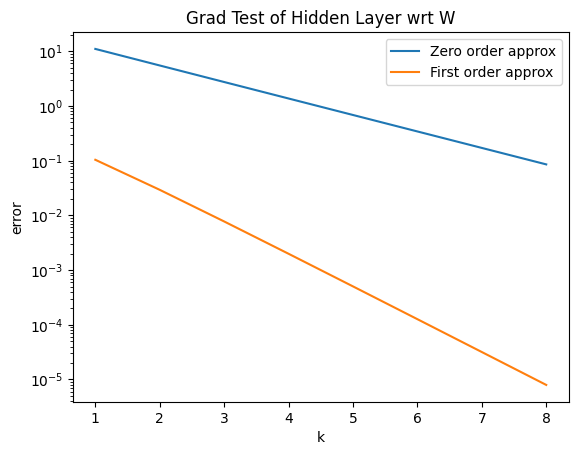




Hidden layer 2 jacobian test  wrt x,w :



k	error order 1 		 error order 2
1 	 19.18390485429424 	 2.28189970924808
2 	 10.126369824952803 	 0.6065324568183428
3 	 5.211362047589091 	 0.1550890932964819
4 	 2.644093139345472 	 0.03913243109732889
5 	 1.331789264749574 	 0.009823520471826441
6 	 0.668345751333959 	 0.002460641276741171
7 	 0.33478745905370033 	 0.0006157372516497617
8 	 0.1675475928629453 	 0.00015400528971554195


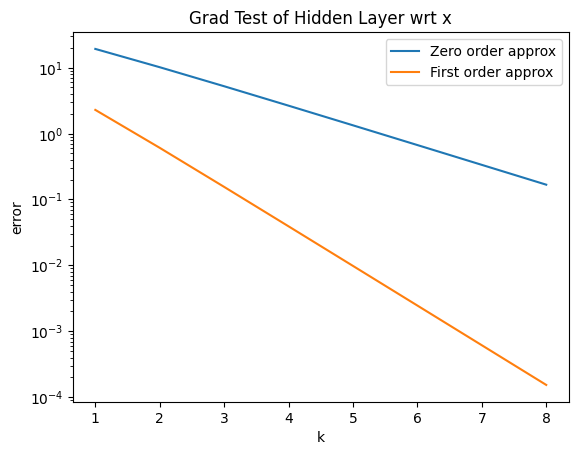

k	error order 1 		 error order 2
1 	 5.737379110803261 	 0.6887185536270977
2 	 3.0492518007224874 	 0.16379703149269176
3 	 1.5667518530346456 	 0.03977256307294397
4 	 0.7934735637454935 	 0.009788644308287076
5 	 0.3992036977456337 	 0.0024274062812708053
6 	 0.2002111968289455 	 0.0006043551844925332
7 	 0.1002570009287922 	 0.0001507750779410344
8 	 0.05016623355245997 	 3.765445089243258e-05


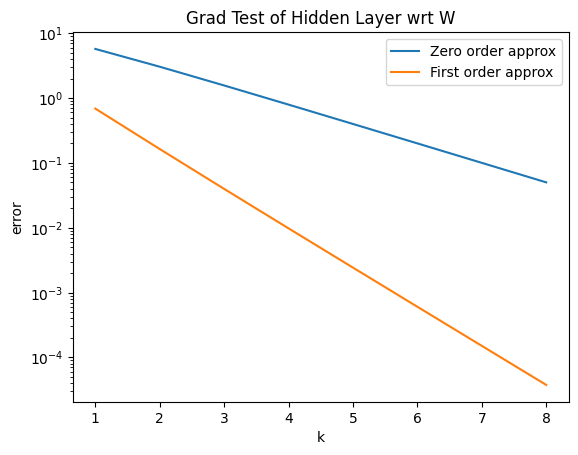




Hidden layer 3 jacobian test  wrt x,w :



k	error order 1 		 error order 2
1 	 36.20997807414872 	 1.6763245479577478
2 	 17.694656181351036 	 0.42782941825554843
3 	 8.741348711141711 	 0.10793532959397112
4 	 4.343807113969319 	 0.027100423195449252
5 	 2.165142301317047 	 0.006788955930112195
6 	 1.0808755799034202 	 0.001698907209949141
7 	 0.5400132670963558 	 0.0004249307496237975
8 	 0.2699004260464619 	 0.00010625787309237467


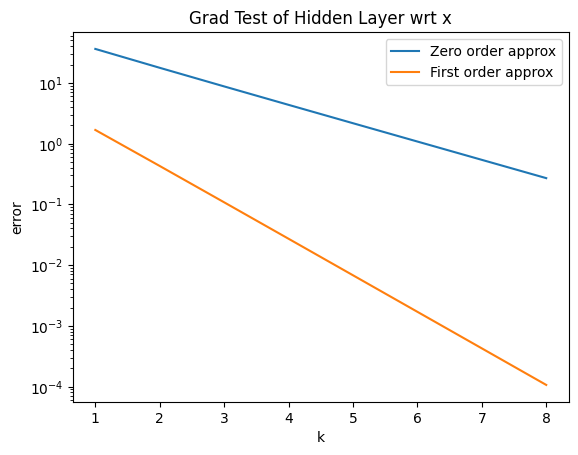

k	error order 1 		 error order 2
1 	 23.991730378569713 	 2.3213914171752634
2 	 12.592304016422219 	 0.5642568814502766
3 	 6.439609823820987 	 0.1386706251152532
4 	 3.2547948134005793 	 0.03434541106754807
5 	 1.6360254464879063 	 0.00854466574615742
6 	 0.820154187277339 	 0.002130868839685718
7 	 0.41061047842948994 	 0.0005320496290295296
8 	 0.20543833540472178 	 0.0001329286245379535


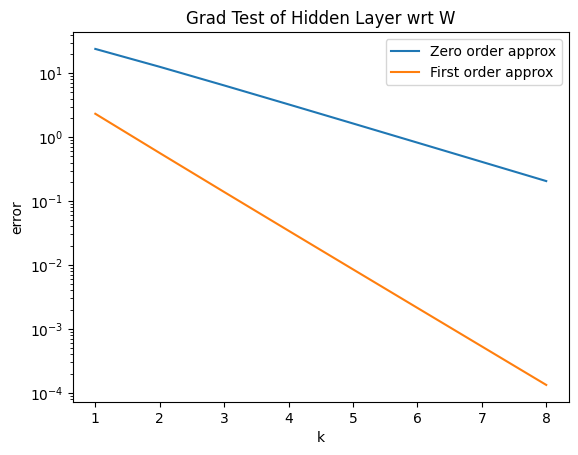




Hidden layer 4 jacobian test  wrt x,w :



k	error order 1 		 error order 2
1 	 32.230323233251625 	 2.5589654024904576
2 	 15.582050618359062 	 0.7463717029785357
3 	 7.614473644701434 	 0.19663418701111368
4 	 3.759090520957102 	 0.05017079211199871
5 	 1.8671137306391756 	 0.01265386621662401
6 	 0.9304063476316742 	 0.0031764154203983708
7 	 0.4644106300727344 	 0.000795663967096516
8 	 0.23200659042913685 	 0.00019910737626105401


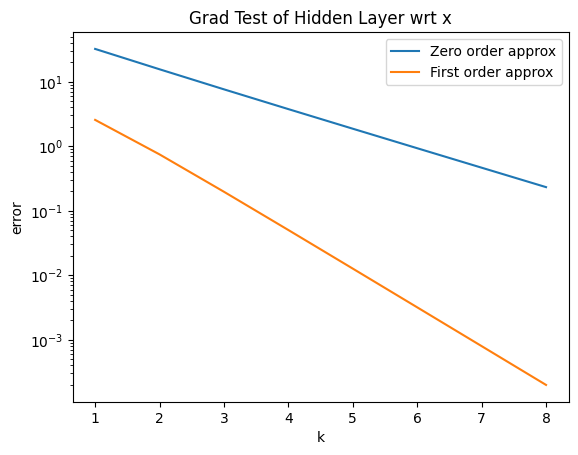

k	error order 1 		 error order 2
1 	 4.956230478108978 	 0.6915942892647422
2 	 2.286349248615352 	 0.1540311541932624
3 	 1.1022152321843919 	 0.03605618497334717
4 	 0.5417774127414532 	 0.008697889135930836
5 	 0.2686739760645196 	 0.002134214261729994
6 	 0.13379835185520506 	 0.0005284709538386778
7 	 0.06676641958273422 	 0.00013147913205102668
8 	 0.03335025997358798 	 3.27897482179651e-05


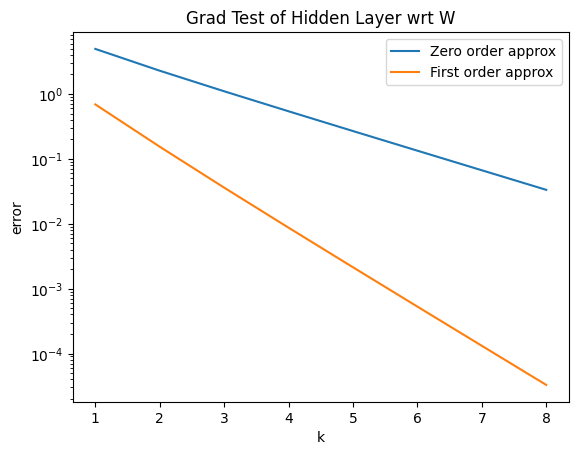

In [35]:
# first layer :

inputs = xtrain

last, rest = forward(inputs, weights)

# # rest of the layers :
for layer in range(len(weights) - 1):
  print(f"\n\n\nHidden layer {layer + 1} jacobian test  wrt x,w :\n\n\n")
  direct_jacobian_test_transposed_x(rest[layer], weights[layer], 8)
  direct_jacobian_test_transposed_w(rest[layer], weights[layer], 8)


#  Back - Propagation


In [36]:
# gardient of softmax wrt X.
def grad_x_softmax(output, labels, weights):
    m = labels.shape[0] # num of samples.
    pred_actu = (output.T - labels).T

    return (weights[-1].T @ pred_actu) / m # (2,5) @ (5,4) = (2,4).

def grad_w_softmax(input, labels, weights):
    m = labels.shape[0] # num of samples.
    temp = []
    output = softmax (weights[-1] @ input)

    pred_actu = (output.T - labels).T

    for p in range(labels.shape[1]): # num of classes.
        temp.append(np.dot(input, (pred_actu[p]))/m) # (5, 25000) x (4,1) -> (2,5)
    return temp


def backward(inputs, labels, weights):
    softmax_output, intermediates = forward(inputs, weights)
    v = 0
    # print(f"[DEBUG - backward] labels : {labels.shape}")
    # print(f"[DEBUG - backward] inputs : {inputs.shape}")
    # gradw_soft = np.stack(grad_w_softmax(softmax_output[:-1:], labels, weights), axis=0)
    dw = grad_w_softmax(intermediates[-1], labels, weights)
    dw = np.array(dw)

    gradients = [dw] # gradwsoftmax

    v = grad_x_softmax(softmax_output, labels ,weights)
    # print(f"v {v.shape} : \n {v}")
    for i in range(len(intermediates) - 2, -1, -1):
          # print(f"Iteration i: {i} : \n intermediates[i] : {intermediates[i].shape} \n weights[i] : {weights[i].shape} \n v : {v.shape}")
          # print(f"grad_w_layers : {grad_w_layers(intermediates[i - 1], weights[i], v).shape}")
          dw = grad_w_layers(intermediates[i], weights[i], v)
          # print(f"dw : {(grad_w_layers(intermediates[i - 1], weights[i], v).T).shape}")

          gradients.append(dw)
          v =  grad_x_layers(intermediates[i], weights[i], v)

    return gradients

In [37]:
# _ , rest = forward(xtrain, weights)
for i ,w in enumerate(weights) :
  # print(f"rest[{i}]: {rest[i].shape}")
  print(f"w[{i}]: {weights[i].shape}")


gradients  = backward(xtrain, ctrain, weights)[::-1]
print()


for i ,grad in enumerate(gradients) :
  print(f"gradients[{i}]: {np.array(gradients[i]).shape}")

w[0]: (7, 3)
w[1]: (9, 8)
w[2]: (8, 10)
w[3]: (10, 9)
w[4]: (2, 10)

gradients[0]: (7, 3)
gradients[1]: (9, 8)
gradients[2]: (8, 10)
gradients[3]: (10, 9)
gradients[4]: (2, 10)


# Network training





In [38]:
def train_SGD(inputs_train, labels_train, inputs_valid, labels_valid, weights, learning_rate, batch_size, num_epochs):
    train_accuracies = []
    valid_accuracies = []

    # Shuffle training data
    for epoch in range(num_epochs):
        indices = np.random.permutation(inputs_train.shape[1])
        inputs_train_shuffled = inputs_train.T[indices]
        labels_train_shuffled = labels_train[indices]

        for i in range(0, len(inputs_train), batch_size):
            inputs_batch = inputs_train_shuffled[i:i+batch_size].T
            labels_batch = labels_train_shuffled[i:i+batch_size]


            out, _ = forward(inputs_batch,weights)
            loss = compute_loss(out, labels_batch)
            gradw = backward(inputs_batch, labels_batch, weights)[::-1]

            for i in range(len(weights)):
              weights[i] -=  (gradw[i]  * learning_rate)

        # Compute accuracy on training data
        train_accuracy = compute_accuracy(inputs_train, labels_train, weights)
        train_accuracies.append(train_accuracy)

        # Compute accuracy on validation data
        valid_accuracy = compute_accuracy(inputs_valid, labels_valid, weights)
        valid_accuracies.append(valid_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Accuracy = {train_accuracy}, Valid Accuracy = {valid_accuracy}")

    return train_accuracies, valid_accuracies

def compute_accuracy(inputs, labels, weights):
    outputs, _ = forward(inputs, weights)
    predictions = np.argmax(outputs.T, axis=1)
    true_labels = np.argmax(labels, axis=1)


    accuracy = np.mean(predictions == true_labels)
    return accuracy


Epoch 1/500: Train Accuracy = 0.23264, Valid Accuracy = 0.23056
Epoch 2/500: Train Accuracy = 0.27992, Valid Accuracy = 0.27888
Epoch 3/500: Train Accuracy = 0.3704, Valid Accuracy = 0.3664
Epoch 4/500: Train Accuracy = 0.38964, Valid Accuracy = 0.38704
Epoch 5/500: Train Accuracy = 0.35132, Valid Accuracy = 0.34864
Epoch 6/500: Train Accuracy = 0.4858, Valid Accuracy = 0.48448
Epoch 7/500: Train Accuracy = 0.44688, Valid Accuracy = 0.44464
Epoch 8/500: Train Accuracy = 0.46516, Valid Accuracy = 0.47056
Epoch 9/500: Train Accuracy = 0.50528, Valid Accuracy = 0.50256
Epoch 10/500: Train Accuracy = 0.50832, Valid Accuracy = 0.50352
Epoch 11/500: Train Accuracy = 0.43184, Valid Accuracy = 0.4272
Epoch 12/500: Train Accuracy = 0.47932, Valid Accuracy = 0.47392
Epoch 13/500: Train Accuracy = 0.43952, Valid Accuracy = 0.43792
Epoch 14/500: Train Accuracy = 0.51656, Valid Accuracy = 0.51008
Epoch 15/500: Train Accuracy = 0.60964, Valid Accuracy = 0.60512
Epoch 16/500: Train Accuracy = 0.58476

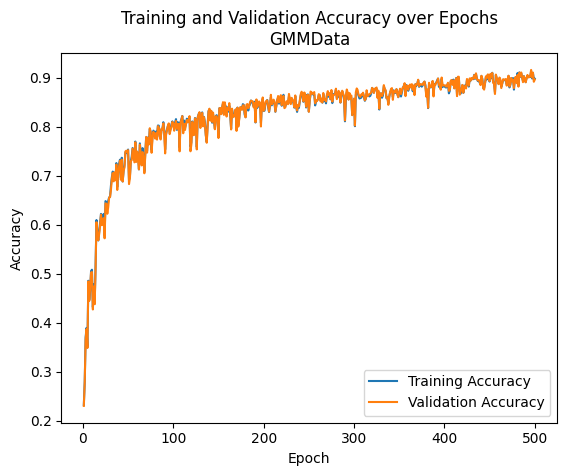

In [43]:

# for i,w in enumerate(weights) :
#   print(f"[DEBUG] weights[{i}] with shape {weights[i].shape} :\n {weights[i]}")

# print(xtrain.shape)
num_epochs = 500
weightsk = weights
train_accuracies, valid_accuracies = train_SGD(xtrain, ctrain, xvalid, cvalid, weights=weightsk, learning_rate=0.2,
                                               num_epochs=num_epochs, batch_size = 64)

epochs = range(1, num_epochs+1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs\nGMMData')
plt.legend()
plt.show()


# Test for the whole Network



In [44]:
# #test for the whole Network .

def compute_loss_and_gradients(inputs, labels, weights):
    softmax_output, _ = forward(inputs, weights)
    loss = compute_loss(softmax_output , labels)
    gradients = backward(inputs, labels, weights)[::-1]
    return loss, gradients

def gradient_test_whole_network(inputs, labels, weights, num_steps):
    F0, gradients = compute_loss_and_gradients(inputs, labels, weights)

    y0 = np.zeros(num_steps)
    y1 = np.zeros(num_steps)

    epsilon = 0.1

    d = [np.random.randn(*w.shape) for w in weights]

    print("k\terror order 1 \t\t error order 2")
    for k in range(1, num_steps + 1):
        epsk = epsilon * (0.5 ** k)

        # Perturb each layer's weights
        perturbed_weights = [w +  epsk * d_w for w, d_w in zip(weights, d)]
        Fk, _ = compute_loss_and_gradients(inputs, labels, perturbed_weights)

        first_order_approximation = [np.sum(grad * d_w) for grad, d_w in zip(gradients, d)]
        F1 = F0 + epsk * np.sum(first_order_approximation)

        y0[k - 1] = abs(Fk - F0)
        y1[k - 1] = abs(Fk - F1)
        print(k, "\t", y0[k - 1], "\t", y1[k - 1])

    plt.semilogy(range(1, num_steps + 1), y0)
    plt.semilogy(range(1, num_steps + 1), y1)

    plt.legend(("Zero order approx", "First order approx"))
    plt.title("Gradient Test for The Whole Standrad NN")
    plt.xlabel("k")
    plt.ylabel("error")

k	error order 1 		 error order 2
1 	 0.051714335669582834 	 0.057585284893832855
2 	 0.011522272320541926 	 0.014457746932666937
3 	 0.0021921473757010035 	 0.003659884681763481
4 	 0.00018884845858280208 	 0.0009227171116140687
5 	 0.00013519832681679889 	 0.0002317359996988344
6 	 0.00012539658210186655 	 5.807058115592234e-05
7 	 7.719860277599633e-05 	 1.4534978852898117e-05
8 	 4.223086351129446e-05 	 3.6359273031805195e-06


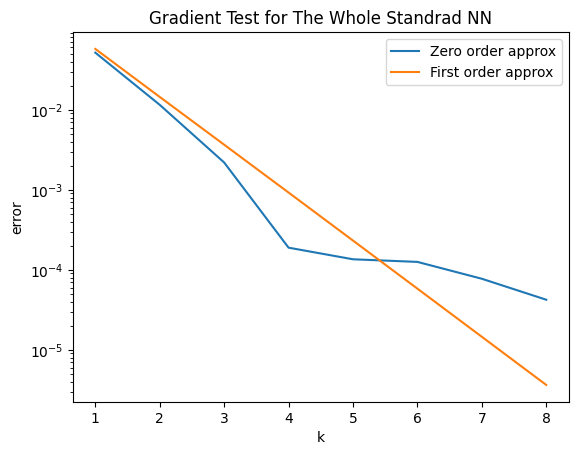

In [46]:
gradient_test_whole_network(xtrain, ctrain, weights, 8)
# compute_loss_and_gradients(xtrain, ctrain , weights)